# Try 1

## Prepare Environments

In [ ]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

In [ ]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git

In [ ]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GoundingDINO"))

In [ ]:
os.chdir('/content/GroundingDINO')

In [ ]:
!pip install -e .

In [ ]:
! pip install diffusers transformers accelerate scipy safetensors

In [ ]:
!nvidia-smi

In [ ]:
# If you have multiple GPUs, you can set the GPU to use here.
# The default is to use the first GPU, which is usually GPU 0.
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

In [ ]:
import argparse
import os
import copy

import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

## Load Grounding DINO model

In [ ]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

In [ ]:
# Use this command for evaluate the Grounding DINO model
# Or you can download the model by yourself
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

In [ ]:
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

## Load SAM model

In [ ]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [ ]:
sam_checkpoint = 'sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=device)
sam_predictor = SamPredictor(sam)

## Load stable diffusion inpainting models

In [ ]:
from diffusers import StableDiffusionInpaintPipeline

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)

pipe = pipe.to("cuda")

## Load demo image

In [ ]:
import io


def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(io.BytesIO(r.content)) as im:
        im.save(image_file_path)

    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

download_image(image_url, local_image_path)

In [ ]:
local_image_path = '../assets/ADE_val_00000132.jpg'

## Run Grounding DINO for detection

In [ ]:
TEXT_PROMPT = "wall"
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

image_source, image = load_image(local_image_path)

boxes, logits, phrases = predict(
    model=groundingdino_model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
annotated_frame = annotated_frame[...,::-1] # BGR to RGB

In [ ]:
Image.fromarray(image_source)

In [ ]:
Image.fromarray(annotated_frame)

## Run the segmentation model

In [ ]:
# set image
sam_predictor.set_image(image_source)

In [ ]:
# box: normalized box xywh -> unnormalized xyxy
H, W, _ = image_source.shape
boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

In [ ]:
transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(device)
masks, _, _ = sam_predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = transformed_boxes,
            multimask_output = False,
        )


In [ ]:
def show_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

In [ ]:
annotated_frame_with_mask = show_mask(masks[0][0], annotated_frame)

In [ ]:
Image.fromarray(annotated_frame_with_mask)

## Image Inpainting

In [ ]:
image_mask = masks[0][0].cpu().numpy()

In [ ]:
image_source_pil = Image.fromarray(image_source)
annotated_frame_pil = Image.fromarray(annotated_frame)
image_mask_pil = Image.fromarray(image_mask)
annotated_frame_with_mask_pil = Image.fromarray(annotated_frame_with_mask)

In [ ]:
image_mask_pil

In [ ]:
# resize for inpaint
image_source_for_inpaint = image_source_pil.resize((512, 512))
image_mask_for_inpaint = image_mask_pil.resize((512, 512))

In [ ]:
prompt = "A sofa, high quality, detailed, cyberpunk, futuristic, with a lot of details, and a lot of colors."
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
image_inpainting = pipe(prompt=prompt, image=image_source_for_inpaint, mask_image=image_mask_for_inpaint).images[0]

In [ ]:
image_inpainting = image_inpainting.resize((image_source_pil.size[0], image_source_pil.size[1]))

In [ ]:
image_inpainting

# Try 2

## Environment Setting

In [2]:
# Acquring GPU
!nvidia-smi

import os
HOME = os.getcwd()
print("HOME:", HOME)


# Installing Grounding DINO, SAM and other dependencies
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!pip install -q -e .

%cd {HOME}
import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!pip uninstall -y supervision
!pip install -q supervision==0.6.0
import supervision as sv
print(sv.__version__)

!pip install -q roboflow


# Downloading model weights
import os
GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))

%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

import os
GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(GROUNDING_DINO_CHECKPOINT_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH))

%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

import os
SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))


# Loading model
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%cd {HOME}/GroundingDINO
from groundingdino.util.inference import Model
grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

SAM_ENCODER_VERSION = "vit_h"
from segment_anything import sam_model_registry, SamPredictor
sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

Wed Jun 14 07:46:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Zero-Shot Object detection with Grounding DINO

In [ ]:
import cv2
import supervision as sv

def detect_classes():
    # detect objects
    detections = grounding_dino_model.predict_with_classes(
        image=image,
        classes=CLASSES,
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )

    # annotate image with detections
    box_annotator = sv.BoxAnnotator()
    labels = [
        f"{CLASSES[class_id]} {confidence:0.2f}"
        for _, _, confidence, class_id, _
        in detections]
    annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

    %matplotlib inline
    sv.plot_image(annotated_frame, (16, 16))

    return detections

## Prompting SAM with detected boxes

In [ ]:
import numpy as np
import math
import cv2
from segment_anything import SamPredictor


def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)


def annotate_detections():
    # convert detections to masks
    detections.mask = segment(
        sam_predictor=sam_predictor,
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        xyxy=detections.xyxy
    )

    # annotate image with detections
    box_annotator = sv.BoxAnnotator()
    mask_annotator = sv.MaskAnnotator()
    labels = [
        f"{CLASSES[class_id]} {confidence:0.2f}"
        for _, _, confidence, class_id, _
        in detections]
    annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

    %matplotlib inline
    sv.plot_image(annotated_image, (16, 16))
    return annotated_image


def plot_binary_mask():

    grid_size_dimension = math.ceil(math.sqrt(len(detections.mask)))

    titles = [
        CLASSES[class_id]
        for class_id
        in detections.class_id
    ]

    # detections.mask[0] = np.array([np.bitwise_xor(detections.mask[0], detections.mask[1])])
    sv.plot_images_grid(
        images=detections.mask,
        titles=titles,
        grid_size=(grid_size_dimension, grid_size_dimension),
        size=(16, 10)
    )

## Load Sample data

In [1]:
f"{HOME}/data"

%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

!git clone https://github.com/devasenan134/mfs.git
%cp mfs/inputs/inputs ./inputs -R
%rm -rf mfs
%cd inputs

NameError: ignored

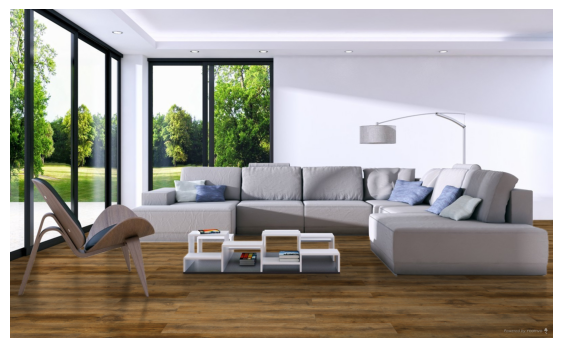

"\nthresh from github, was box_thresh=0.35, text_thresh=0.25\nthen I tried both values with 0.5, it didn't detect anything\nThen again tried box_tresh=0.3 and text_thresh=0.25\n"

In [54]:
img = 'img9/test.jpg'
SOURCE_IMAGE_PATH = f"{HOME}/data/inputs/{img}"
CLASSES = ["all walls", 'floor', 'ceiling']
BOX_TRESHOLD = 0.2
TEXT_TRESHOLD = 0.2

image = cv2.imread(SOURCE_IMAGE_PATH)
sv.plot_image(image, (7, 7))

"""
thresh from github, was box_thresh=0.35, text_thresh=0.25
then I tried both values with 0.5, it didn't detect anything
Then again tried box_tresh=0.3 and text_thresh=0.25
"""

## Processing time


In [55]:
import time

st = time.time()
detections = detect_classes()
annotate_detections()
et = time.time()

plot_binary_mask()
print("Execution time: {:.3f}s".format(et-st))

Output hidden; open in https://colab.research.google.com to view.

## Save labels in Pascal VOC

In [ ]:
ANNOTATIONS_DIRECTORY = os.path.join(HOME, 'annotations')

MIN_IMAGE_AREA_PERCENTAGE = 0.002
MAX_IMAGE_AREA_PERCENTAGE = 0.80
APPROXIMATION_PERCENTAGE = 0.75

In [ ]:
sv.Dataset(
    classes=CLASSES,
    images=images,
    annotations=annotations
).as_pascal_voc(
    annotations_directory_path=ANNOTATIONS_DIRECTORY,
    min_image_area_percentage=MIN_IMAGE_AREA_PERCENTAGE,
    max_image_area_percentage=MAX_IMAGE_AREA_PERCENTAGE,
    approximation_percentage=APPROXIMATION_PERCENTAGE
)

## Automated Masking

In [ ]:
%cd {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

import os
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

# Load model
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
MODEL_TYPE = "vit_h"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
def automated_masking():
    image = cv2.imread(SOURCE_IMAGE_PATH)

    # Mask generation
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sam_result = mask_generator.generate(image_rgb)

    # Annotation using supervision
    mask_annotator = sv.MaskAnnotator()
    detections = sv.Detections.from_sam(sam_result=sam_result)
    annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
    sv.plot_images_grid(
        images=[image, annotated_image],
        grid_size=(1, 2),
        titles=['source image', 'segmented image']
    )